Name and ID

# Data Driven Strategies

## Importing Required Packages

In [1]:
import apmodule as ap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
plt.style.use('ggplot')
%matplotlib inline

<b>A note on</b> `random_state`:
All computers have what is called a psuedo random number generator. This produces seemingly random numbers, i.e., with enough iteratons it will eventually repeat a sequence. Where the number generator is started is known as the seed. When one specifies `random_state` parameter they set the random seed. Therefore, a specific integer value ensures a fixed dataset whereas the default `None` shuffles the dataset. 

Why is this important? <br>
Because it ensures reproducibilty. A fixed dataset means a fixed result. Well for the first run at least. There is usually some variance with repeated runs, so the results change slightly. Now different integers will have different shuffles of the data therefore making them unique, and thus changing the results. After repeated testing, I have used the ones most optimal in terms of the Information Ratio. Of course, there is nothing special about the number 42, other than it being the answer to "the Ultimate Question of Life, the Universe, and Everything". 

One might also see some variance with a change in environment i.e., the machine running the code.

## Required Functions:

In [2]:
def tree_model(criterion="gini", max_depth=4):
    """
    Generates a classifier object
    
    :param criterion: criteria of desicion tree classifier default gini
    :param max_depth: maximum depth of desicion tree
    """
    # Creating the classifier object
    clf = DecisionTreeClassifier(criterion = criterion,
            random_state = 42, max_depth=max_depth)

    return clf

def predict_tree_model(clf_object, X_train, y_train, X_test):
    """
    Predicts target variable
    
    :param clf_object: classifier object
    :param X_train: features training set
    :param y_train: target training set
    :param X_test: feature test set
    """
    # Fitting the model on training data
    clf_object.fit(X_train, y_train)
    
    # returning prediction for test and train sets
    return clf_object.predict(X_test), clf_object.predict(X_train)

def cal_confusion(y_test, y_test_pred):
    """
    Prints the Confusion Matrix, True Positivity Rate, and True Negativity Rate
    
    :param y_test: target variable test set
    :param y_test_pred: model prediction of target variable for test set
    """
    # Printing Confusion Matrix
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:\n",
          confusion_matrix,'\n')
    
    # Calculating and printing TPR and FPR
    TPR = round(confusion_matrix[1][1]/confusion_matrix[1].sum(), 5)
    TNR = round(confusion_matrix[0][0]/confusion_matrix[0].sum(), 5)
    print(f'{TPR = }')
    print(f'{TNR = }\n')
      
def cal_metrics(y_test, y_train, y_test_pred, y_train_pred):
    """
    Calculates and Prints several metrics to measure model performance
    
    :param y_test: target variable test set
    :param y_train: target variable train set
    :param y_test_pred: model prediction of target variable for test set
    :param y_train_pred: model prediction of target variable for train set
    """
    # calling cal_confusion to print confusion matrix
    cal_confusion(y_test, y_test_pred)
    
    # printing in sample and out of sample accuracy score
    print('In-Sample Accuracy:\n', 
          round(metrics.accuracy_score(y_train, y_train_pred), 3))
    print('\nOut-of-Sample Accuracy:\n', 
          round(metrics.accuracy_score(y_test, y_test_pred), 3))

def plot_pie_chart(data):
    """
    Plots Feature Importance Pie Chart
    
    :param data: feature importance dataset
    """
    # Creating a subplot
    fig, ax = plt.subplots(figsize=(11,5))
    
    # Plottng and removing ylabels in the process
    data.plot(kind='pie', y='Feature Importance', 
              labels=None, ax=ax, title='Feature Importance', fontsize=14)
    
    # Setting legend box position
    ax.legend(labels=data.index, bbox_to_anchor=[0.89,0.9])
    
    # Removing Y axis
    ax.yaxis.set_visible(False)

def ml_analysis(prediction, prices):
    """
    Provided function for simulated investment performance analysis
    
    :param prediction: pandas series of model prediction of test set
    :param prices: pandas series of historical price data
    """
    #We capture the name of the factor using the .name attribute to use it later
    pred_name = prediction.name
    
    #We look for the tag of the best and worst outcome
    best = prediction.max()
    worst = prediction.min()
    
    #We calculate the future returns
    future_returns = np.log(prices.groupby('id').shift(-1) / prices).rename('fut_ret')
    
    #We join the signal with the future returns
    data = prediction.to_frame().join(future_returns).dropna()
    
    #We calculate the average return of the groups
    portfolios = data.groupby(['date',pred_name]).mean()
    
    #We rearrange the results in order to have one group per column
    port_returns = portfolios['fut_ret'].unstack(level=1) 
    
    #We calculate the benchmark return
    benchmark_return = data.groupby('date')['fut_ret'].mean().rename('Benchmark')
    port_returns = port_returns.join(benchmark_return.to_frame())
    
    #We calculate the return of the zero-investment portfolios
    port_returns['Active'] = port_returns[best] - port_returns['Benchmark']
    port_returns['Neutral'] = port_returns[best] - port_returns[worst]
    
    diagnostics = ap.diagnostics(port_returns)

    return port_returns, diagnostics 


## Loading and preprocessing the Data

<b>A note on why</b> `int > NaN = False`:
Well because, Python. That's how Python works. This implies than when we shift the returns data to compare this month and next we will have a NaN value that will be added to our target variable as a `False` or rather $0$. Since, classification models are very sensitive to data, this will clearly affect our model and bias it in ways that wouldn't be predictable. Usually one substitutes `NaN` values but since this is binary data, that is not possible. Which is why I have decided to drop those rows from the dataset before training the model.

In [3]:
# we load the prices and calculate the future returns
prices = pd.read_csv('Prices.zip', parse_dates=['date']).set_index(['id', 'date'])
returns = np.log(prices['price'].groupby('id').shift(-1) / prices['price']).rename('fut_ret')

# we load the factors data
factors = pd.read_csv('A2_Data.zip', parse_dates=['date']).set_index(['id', 'date'])

# we join the two dataframes into one
sample = factors.join(returns).dropna()

# we calculate the median and join into dataframe
median = sample.groupby('date')['fut_ret'].median().rename('median')
sample = sample.join(median).dropna()

# we calculate the signal and turn boolean values into numerical for better modelling
sample['target'] = sample['fut_ret'].groupby('id').shift(0) > sample['median'].groupby('id').shift(1)
structure = {True: 1, False: 0}
sample['target'] = sample['target'].map(structure)

# we drop the first row of every id
sample.drop(sample.groupby('id').head(1).index, inplace=True)

sample

gp     mom12       epq    n_beta  fed_rate  \
id    date                                                           
10001 2008-06-30 -0.015474  0.861761  0.418016  1.376280      2.01   
      2008-07-31 -0.028595  0.970066  0.447758  1.371320      2.00   
      2008-08-29 -0.027791  0.848705  0.295819  1.379083      1.81   
      2008-10-31 -0.644914  0.670253  0.149691  1.362214      0.39   
      2008-11-28 -0.643210  1.342070  0.182001  1.356757      0.16   
...                    ...       ...       ...       ...       ...   
93436 2021-07-30  0.190919  1.518636  0.166994 -0.640392      0.09   
      2021-08-31  0.169477  0.869417  0.138092 -0.637089      0.08   
      2021-09-30  0.157910 -0.002322  0.133930 -0.609448      0.08   
      2021-10-29  0.324550  0.469341  0.148780 -0.729108      0.08   
      2021-11-30  0.333179  1.899733  0.159068 -0.712888      0.08   

                  unemploy_rate   fut_ret    median  target  
id    date                                                   
10001 2008-06-30            5.8 -0.054481  0.006252       1  
      2008-07-31            6.1 -0.019921  0.022162       0  
      2008-08-29            6.1 -0.147774 -0.102995       0  
      2008-10-31            6.8 -0.139401 -0.127733       0  
      2008-11-28            7.3  0.144956  0.023056       1  
...                         ...       ...       ...     ...  
93436 2021-07-30            5.2  0.068224  0.011490       1  
      2021-08-31            4.7  0.052633 -0.046132       1  
      2021-09-30            4.6  0.362230  0.029903       1  
      2021-10-29            4.2  0.027238 -0.037697       0  
      2021-11-30            3.9 -0.079968  0.041303       0  

[322512 rows x 9 columns]

## Splitting into Train and Test sets

In [4]:
# we select features/factors for the model
features = ['gp', 'mom12', 'epq', 'n_beta', 'fed_rate', 'unemploy_rate']

# X is the factors and y is the target variable
X = sample[features]
y = sample[['target']]

# we split the data into train and test sets categorised by date
idx = pd.IndexSlice
X_train, X_test = X.loc[idx[:,'2008-01-01':'2017-12-31'], :], X.loc[idx[:,'2018-01-01':'2021-12-31'], :]
y_train, y_test = y.loc[idx[:,'2008-01-01':'2017-12-31'], :], y.loc[idx[:,'2018-01-01':'2021-12-31'], :]

## Predicting through Decision Tree Models

In [5]:
# Saving the classifier object
clf = tree_model()

# Making prediction based on model
y_test_pred, y_train_pred = predict_tree_model(clf, X_train, y_train, X_test)

# Calculating various metrics
cal_metrics(y_test, y_train, y_test_pred, y_train_pred)
print('\n10-Folds Cross Validation \nAverage Accuracy:\n', 
          round(cross_val_score(tree_model(), X, y, cv=10).mean(), 3))

Confusion Matrix:
 [[35156  9607]
 [30783  8696]] 

TPR = 0.22027
TNR = 0.78538

In-Sample Accuracy:
 0.537

Out-of-Sample Accuracy:
 0.521

10-Folds Cross Validation 
Average Accuracy:
 0.536


In [6]:
# Making predictions based on model
y_test_pred1, y_train_pred1 = predict_tree_model(tree_model(criterion="entropy"), X_train, y_train, X_test)

# Calculating various metrics
cal_metrics(y_test, y_train, y_test_pred1, y_train_pred1)
print('\n10-Folds Cross Validation \nAverage Accuracy:\n', 
          round(cross_val_score(tree_model(criterion="entropy"), X, y, cv=10).mean(), 3))

Confusion Matrix:
 [[35667  9096]
 [31811  7668]] 

TPR = 0.19423
TNR = 0.7968

In-Sample Accuracy:
 0.537

Out-of-Sample Accuracy:
 0.514

10-Folds Cross Validation 
Average Accuracy:
 0.534


[Text(0.5446428571428571, 0.9, 'unemploy_rate <= 9.95\ngini = 0.5\nsamples = 100.0%\nvalue = [0.513, 0.487]'),
 Text(0.2857142857142857, 0.7, 'fed_rate <= 2.005\ngini = 0.5\nsamples = 99.1%\nvalue = [0.51, 0.49]'),
 Text(0.14285714285714285, 0.5, 'fed_rate <= 0.185\ngini = 0.5\nsamples = 96.5%\nvalue = [0.515, 0.485]'),
 Text(0.07142857142857142, 0.3, 'fed_rate <= 0.175\ngini = 0.5\nsamples = 63.6%\nvalue = [0.49, 0.51]'),
 Text(0.03571428571428571, 0.1, 'gini = 0.5\nsamples = 59.2%\nvalue = [0.503, 0.497]'),
 Text(0.10714285714285714, 0.1, 'gini = 0.44\nsamples = 4.4%\nvalue = [0.327, 0.673]'),
 Text(0.21428571428571427, 0.3, 'unemploy_rate <= 5.05\ngini = 0.492\nsamples = 32.9%\nvalue = [0.562, 0.438]'),
 Text(0.17857142857142858, 0.1, 'gini = 0.5\nsamples = 19.7%\nvalue = [0.508, 0.492]'),
 Text(0.25, 0.1, 'gini = 0.46\nsamples = 13.2%\nvalue = [0.642, 0.358]'),
 Text(0.42857142857142855, 0.5, 'unemploy_rate <= 5.45\ngini = 0.445\nsamples = 2.6%\nvalue = [0.335, 0.665]'),
 Text(0.35

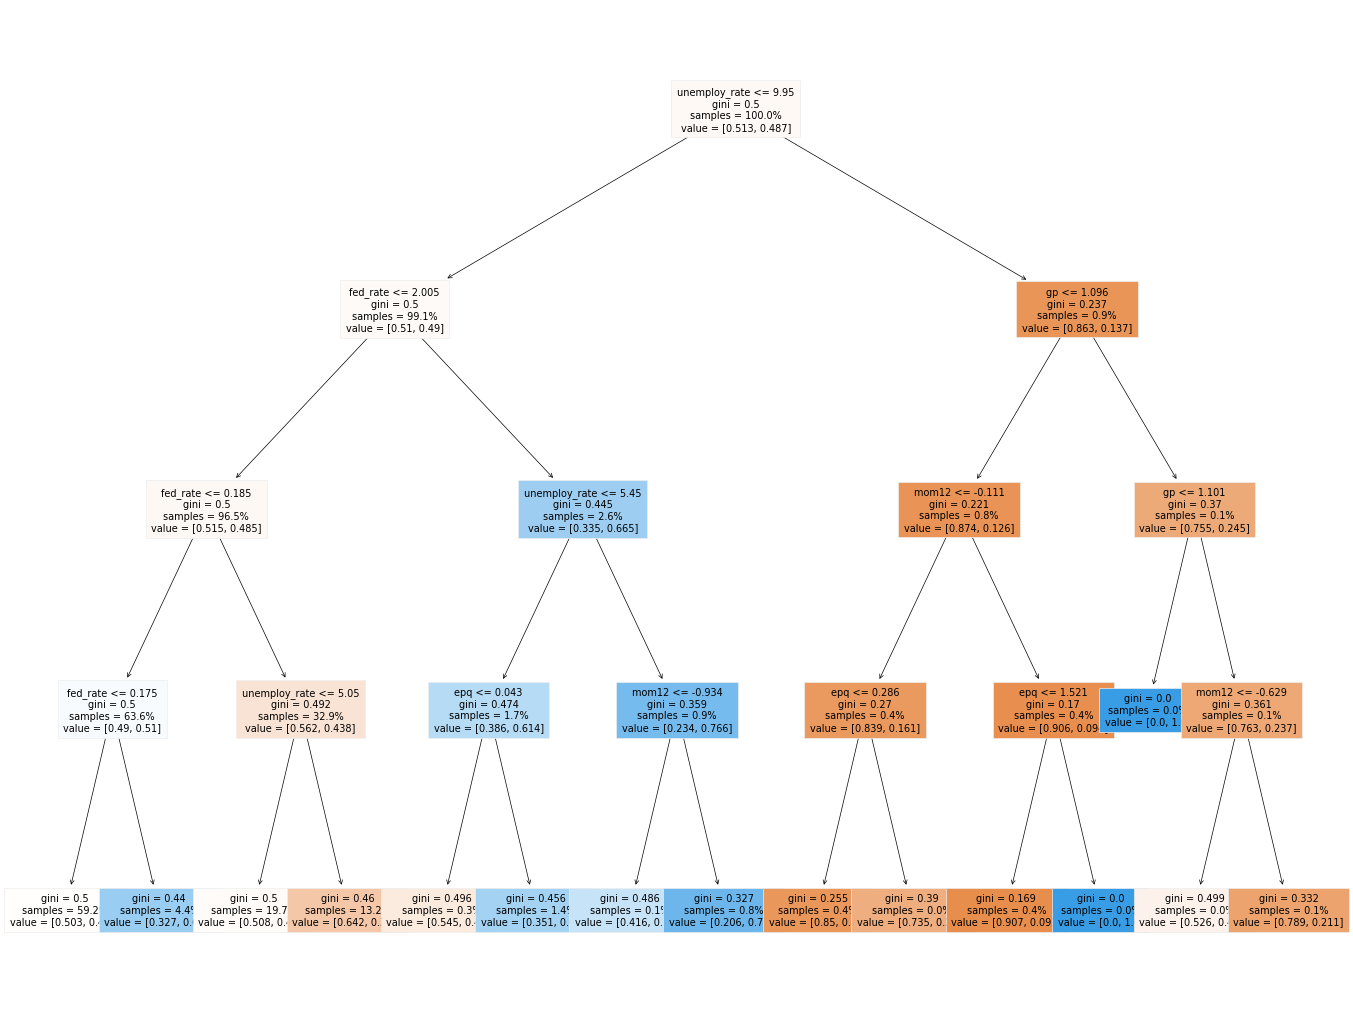

In [7]:
# Plotting the tree
plt.figure(figsize=(17,13))
plot_tree(clf, fontsize=7, feature_names = X.columns, filled=True, proportion=True)

In [8]:
# Saving feature importance into a dataframe
features = pd.DataFrame(clf.feature_importances_, columns=['Feature Importance'], index=X.columns)
features

,Feature Importance
gp,0.002512
mom12,0.009919
epq,0.017279
n_beta,0.000000
fed_rate,0.530711
unemploy_rate,0.439579


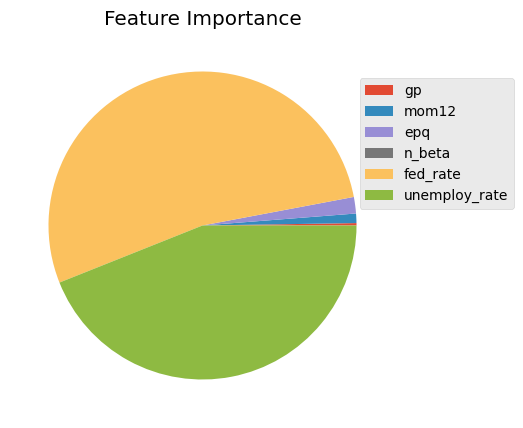

In [9]:
# Plotting the feature importance data
plot_pie_chart(features)

In [10]:
# Converting into series and renaming for no reason
os_pred = y_test.squeeze().rename('Winner')

# Analysing through given function
ret, dia = ml_analysis(os_pred, prices.squeeze())
dia

,0,1,Benchmark,Active,Neutral
Mean Return,-1.233046,1.293280,0.021519,1.271761,2.526326
St. Dev.,0.276585,0.175015,0.248602,0.212417,0.246979
RR Ratio,-4.458105,7.389560,0.086561,5.987089,10.228902
% Positive,0.021277,1.000000,0.617021,1.000000,1.000000
Worst Month,-0.379536,0.008337,-0.279673,0.007458,0.143376
Best Month,0.016866,0.263208,0.163361,0.288009,0.523931
Max DrawDown,-1.727000,0.000000,-0.453054,0.000000,0.000000


In [11]:
# Converting into series and renaming
os_pred = pd.Series(y_test_pred.astype('int64'), index = y_test.index).rename('Winner')

# Analysing through given function
ret, dia = ml_analysis(os_pred, prices.squeeze())
dia

,0,1,Benchmark,Active,Neutral
Mean Return,-0.095434,0.018303,0.021519,-0.040881,0.302670
St. Dev.,0.297707,0.244822,0.248602,0.085981,0.203088
RR Ratio,-0.320564,0.074762,0.086561,-0.475464,1.490334
% Positive,0.574468,0.562500,0.617021,0.687500,0.687500
Worst Month,-0.279673,-0.116295,-0.279673,-0.068164,-0.077181
Best Month,0.176838,0.139401,0.163361,0.022194,0.126018
Max DrawDown,-0.675243,-0.042439,-0.453054,0.000000,0.000000


<AxesSubplot:title={'center':'Machine Learning Strategy'}, xlabel='Time', ylabel='Portfolio Value'>

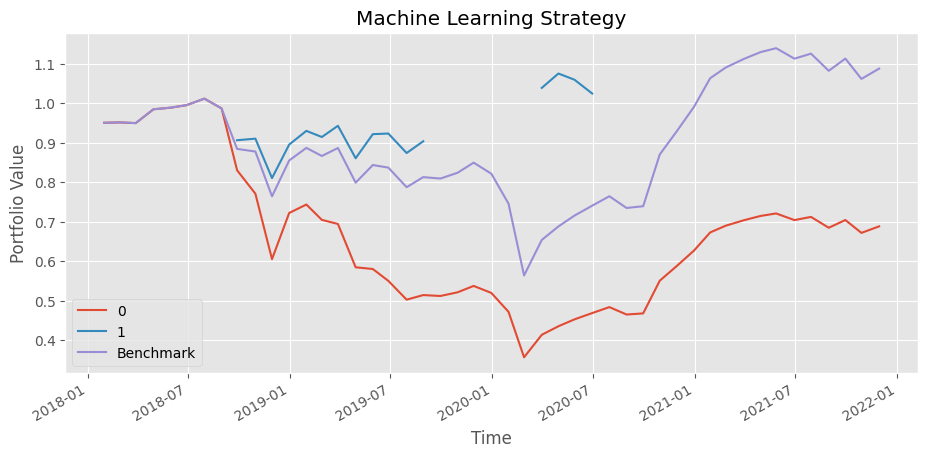

In [12]:
# Calculating portfolio values
port_values = ret.cumsum().apply(np.exp)

# Plotting portfolio
port_values[[0, 1, 'Benchmark']].plot(figsize=(11,5),
                                      title='Machine Learning Strategy', 
                                      ylabel='Portfolio Value', 
                                      xlabel='Time')

In [13]:
ret

,0,1,Benchmark,Active,Neutral
date,,,,,
2018-01-31,-0.050642,NaN,-0.050642,NaN,NaN
2018-02-28,0.000991,NaN,0.000991,NaN,NaN
2018-03-29,-0.001862,NaN,-0.001862,NaN,NaN
2018-04-30,0.036185,NaN,0.036185,NaN,NaN
2018-05-31,0.004124,NaN,0.004124,NaN,NaN
2018-06-29,0.006562,NaN,0.006562,NaN,NaN
2018-07-31,0.016376,NaN,0.016376,NaN,NaN
2018-08-31,-0.024877,NaN,-0.024877,NaN,NaN
2018-09-28,-0.172869,-0.098284,-0.109707,0.011422,0.074585


## Hyperparameter Tuning

<AxesSubplot:title={'center':'Hyperparameter Tuning'}, xlabel='Tree Depth', ylabel='Information Ratio'>

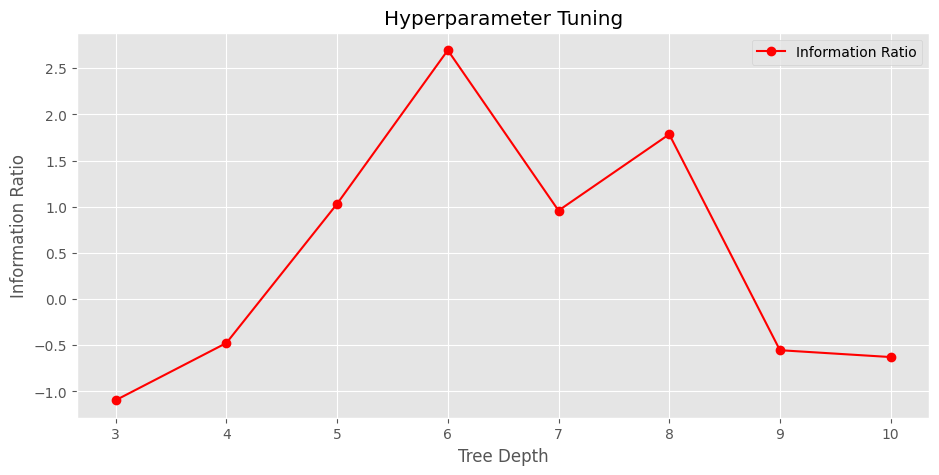

In [14]:
# we create an empty dataframe to store the results
optimal = pd.DataFrame()

# we start the loop
for depth in range(1,11):
    # making predictions based on model
    y_test_pred, y_train_pred = predict_tree_model(tree_model(max_depth=depth), X_train, y_train, X_test)

    # we run the ml_analysis function on each prediction
    os_pred = pd.Series(y_test_pred.astype('int64'), index = y_test.index).rename('Winner')
    ret, dia = ml_analysis(os_pred, prices.squeeze())       
    
    # we save the information ratio into our dataframe
    optimal.loc[depth, 'Information Ratio'] = dia.loc['RR Ratio', 'Active']

# we plot
optimal.plot(figsize=(11,5), 
             style='r-o',
             xlabel='Tree Depth',
             ylabel='Information Ratio',
             title='Hyperparameter Tuning')

In [15]:
optimal

,Information Ratio
1,NaN
2,NaN
3,-1.094971
4,-0.475464
5,1.031602
6,2.695412
7,0.958903
8,1.784973
9,-0.553257
10,-0.627480


## Analysing Optimal Depth Decision Tree

In [16]:
# Calculate metrics for optimal depth decision tree
clf = tree_model(max_depth=optimal['Information Ratio'].idxmax())
y_test_pred, y_train_pred = predict_tree_model(clf, X_train, y_train, X_test)
cal_metrics(y_test, y_train, y_test_pred, y_train_pred)
print('\n10-Folds Cross Validation \nAverage Accuracy:\n', 
          round(cross_val_score(tree_model(), X, y, cv=10).mean(), 3))

Confusion Matrix:
 [[31710 13053]
 [28374 11105]] 

TPR = 0.28129
TNR = 0.7084

In-Sample Accuracy:
 0.57

Out-of-Sample Accuracy:
 0.508

10-Folds Cross Validation 
Average Accuracy:
 0.536


In [17]:
# Calculate investments metrics for optimal depth decision tree
os_pred = pd.Series(y_test_pred.astype('int64'), index = y_test.index).rename('Winner')
ret, dia = ml_analysis(os_pred, prices.squeeze())
dia

,0,1,Benchmark,Active,Neutral
Mean Return,-0.124623,0.174747,0.021519,0.086819,0.463793
St. Dev.,0.318376,0.237077,0.248602,0.032210,0.184048
RR Ratio,-0.391433,0.737089,0.086561,2.695412,2.519951
% Positive,0.568182,0.736842,0.617021,0.789474,0.937500
Worst Month,-0.279673,-0.120658,-0.279673,-0.013913,-0.102570
Best Month,0.201003,0.150484,0.163361,0.029964,0.133628
Max DrawDown,-0.696407,-0.045233,-0.453054,0.000000,0.000000


## Bagging

`random_state = 0` made the most sense here based on the Information Ratio.

In [18]:
rnf = RandomForestClassifier(max_depth=6, random_state = 0)
# we use np.ravel() to change the shape of y to (n_samples,)
rnf.fit(X_train, y_train.values.ravel())

# We build our out-of-sample predictions
y_test_pred = rnf.predict(X_test)

# We calculate confusion matrix and measure the out-of-sample accuracy
cal_confusion(y_test, y_test_pred)
os_accuracy = metrics.accuracy_score(y_test, y_test_pred)
print('Out-of-Sample Accuracy:\n', round(os_accuracy, 3), '\n')

# We can measure the out-of-sample simulated investment performance
os_pred = pd.Series(y_test_pred.astype('int64'), index = y_test.index).rename('Winner')
ret, dia = ml_analysis(os_pred, prices.squeeze())
dia

Confusion Matrix:
 [[24797 19966]
 [20606 18873]] 

TPR = 0.47805
TNR = 0.55396

Out-of-Sample Accuracy:
 0.518 



,0,1,Benchmark,Active,Neutral
Mean Return,-0.158728,-0.032353,0.021519,0.003252,0.285639
St. Dev.,0.337065,0.296890,0.248602,0.062930,0.208998
RR Ratio,-0.470913,-0.108974,0.086561,0.051675,1.366707
% Positive,0.468085,0.633333,0.617021,0.666667,0.666667
Worst Month,-0.279636,-0.344840,-0.279673,-0.065168,-0.102725
Best Month,0.205540,0.135454,0.163361,0.025639,0.144880
Max DrawDown,-0.808162,-0.059663,-0.453054,-0.043945,-0.081549


In [19]:
# Saving feature importance into a dataframe
rnf_features = pd.DataFrame(rnf.feature_importances_, columns=['Feature Importance'], index=X.columns)
rnf_features

,Feature Importance
gp,0.023939
mom12,0.042279
epq,0.084868
n_beta,0.017449
fed_rate,0.428873
unemploy_rate,0.402593


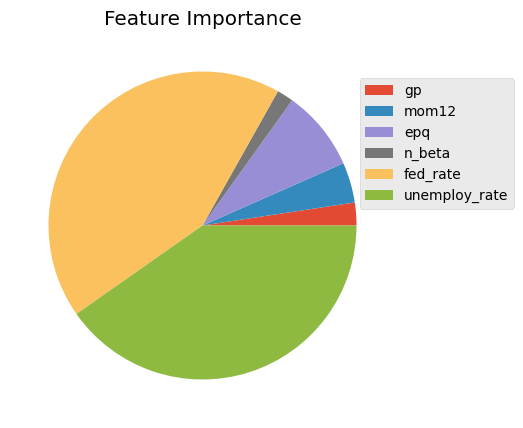

In [20]:
# Plotting the feature importance data
plot_pie_chart(rnf_features)

## Boosting

In [21]:
gbt = GradientBoostingClassifier(max_depth=6, random_state = 42)
# we use np.ravel() to change the shape of y to (n_samples,)
gbt.fit(X_train, y_train.values.ravel())

# We build our out-of-sample predictions
y_test_pred = gbt.predict(X_test)

# We calculate confusion matrix and measure the out-of-sample accuracy
cal_confusion(y_test, y_test_pred)
os_accuracy = metrics.accuracy_score(y_test, y_test_pred)
print('Out-of-Sample Accuracy:', round(os_accuracy, 3), '\n')

# We can measure the out-of-sample simulated investment performance
os_pred = pd.Series(y_test_pred.astype('int64'), index = y_test.index).rename('Winner')
ret, dia = ml_analysis(os_pred, prices.squeeze())
dia

Confusion Matrix:
 [[17469 27294]
 [15469 24010]] 

TPR = 0.60817
TNR = 0.39026

Out-of-Sample Accuracy: 0.492 



,0,1,Benchmark,Active,Neutral
Mean Return,-0.065598,-0.028942,0.021519,-0.021722,0.071335
St. Dev.,0.320246,0.303445,0.248602,0.192724,0.248318
RR Ratio,-0.204838,-0.095377,0.086561,-0.112710,0.287275
% Positive,0.531915,0.522727,0.617021,0.636364,0.636364
Worst Month,-0.279759,-0.249353,-0.279673,-0.283891,-0.284546
Best Month,0.212440,0.304333,0.163361,0.156058,0.156870
Max DrawDown,-0.692110,-0.365144,-0.453054,-0.283891,-0.284546


In [22]:
# Saving feature importance into a dataframe
gbt_features = pd.DataFrame(gbt.feature_importances_, columns=['Feature Importance'], index=X.columns)
gbt_features

,Feature Importance
gp,0.020673
mom12,0.029992
epq,0.053672
n_beta,0.032434
fed_rate,0.338295
unemploy_rate,0.524934


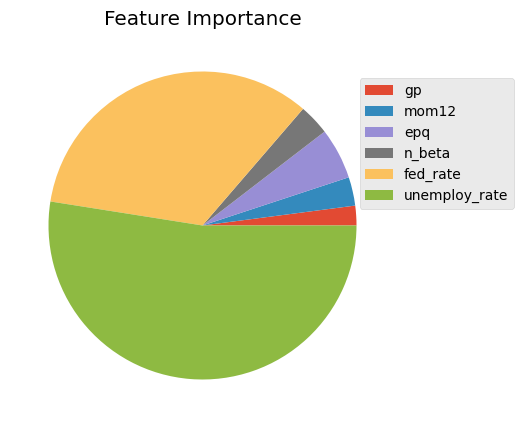

In [23]:
# Plotting the feature importance data
plot_pie_chart(gbt_features)